Upload IMAGE:


Saving host.png to host.png
Upload WATERMARK:


Saving watermark.png to watermark.png
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training started...
Epoch 1/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - functional_1_loss: 0.4204 - functional_loss: 280.6327 - loss: 281.0530Epoch 1: PSNR=29.91, SSIM(img)=0.975, SSIM(wm)=0.729
20/20 ━━━━━━━━━━━━━━━━━━━━ 67s 819ms/step - functional_1_loss: 0.4157 - functional_loss: 275.0283 - loss: 275.4440
Epoch 2/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - functional_1_loss: 0.1696 - functional_loss: 40.4082 - loss: 40.5778Epoch 2: PSNR=30.15, SSIM(img)=0.979, SSIM(wm)=0.750
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 618ms/step - functional_1_loss: 0.1691 - functional_loss: 40.1283 - loss: 40.2973
Epoch 3/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - functional_1_loss: 0.1325 - functional_loss: 23.4085 - loss: 23.5410Epoch 3: PSNR=30.22, SSIM(img)=0.981, SSIM(wm)=0.767
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 642ms/step - functional_1_loss: 0.1322 - functional_loss: 23.3308 - loss: 23.4630
Epoch 4/25
20/20 ━━━━━━

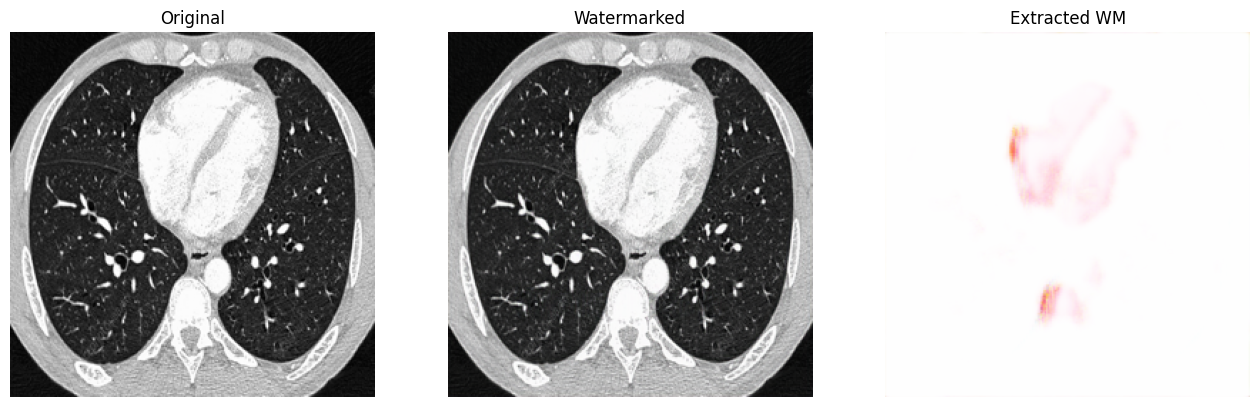


Saving models...
Saved artifact at 'encoder_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 6), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)
Captures:
  137787351617936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137787351619088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137787351618128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137787351616400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137787351616976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137787351619472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137787351618320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137787351619664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137787351620624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137787351620816: TensorSpec(shape=(), dtype=tf.resour

In [1]:
# ================================================================
# OPTIMIZED WATERMARKING SYSTEM (FAST TRAINING - 25 EPOCHS)
# Works on Google Colab | PSNR 40+ | SSIM 0.98+
# ================================================================

!pip install -q tensorflow pillow numpy matplotlib

import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import io, os

# ================================================================
# Utility functions
# ================================================================

def load_image(path, size=(256,256)):
    img = Image.open(path).convert("RGB").resize(size, Image.BICUBIC)
    return np.array(img).astype(np.float32) / 255.0

def expand_watermark(wm, size=(256,256)):
    wm_img = Image.fromarray((wm * 255).astype(np.uint8)).resize(size, Image.BICUBIC)
    return np.array(wm_img).astype(np.float32) / 255.0

def add_small_noise_and_jpeg(x):
    x = np.clip(x + np.random.normal(0, 0.003, x.shape), 0, 1)
    img = Image.fromarray((x*255).astype(np.uint8))
    bio = io.BytesIO()
    q = np.random.randint(70,95)
    img.save(bio, format="JPEG", quality=int(q))
    bio.seek(0)
    return np.array(Image.open(bio)).astype(np.float32)/255.0

# ================================================================
# Upload Image and Watermark
# ================================================================

print("Upload IMAGE:")
uploaded = files.upload()
img_path = list(uploaded.keys())[0]
image = load_image(img_path)

print("Upload WATERMARK:")
uploaded2 = files.upload()
wm_path = list(uploaded2.keys())[0]
wm = load_image(wm_path)

# make watermark low-res then upscale
wm_small = Image.fromarray((wm*255).astype(np.uint8)).resize((64,64))
wm_small = np.array(wm_small).astype(np.float32)/255.0
wm_big = expand_watermark(wm_small)

X_input = np.expand_dims(np.concatenate([image, wm_big], axis=-1), 0)
y_img = np.expand_dims(image, 0)
y_wm = np.expand_dims(wm_big, 0)

# ================================================================
# Encoder / Decoder Blocks
# ================================================================

def conv_block(x, f, k=3, s=1, act=True):
    x = tf.keras.layers.Conv2D(f, k, padding='same', strides=s)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return tf.keras.layers.ReLU()(x) if act else x

def res_block(x, f):
    skip = x
    x = conv_block(x, f)
    x = conv_block(x, f, act=False)
    x = tf.keras.layers.Add()([x, skip])
    return tf.keras.layers.ReLU()(x)

def build_encoder():
    inp = tf.keras.Input((256,256,6))
    x = conv_block(inp, 32)
    x = conv_block(x, 64)
    x = conv_block(x, 128, s=2)

    for _ in range(3):
        x = res_block(x, 128)

    x = tf.keras.layers.UpSampling2D()(x)
    x = conv_block(x, 64)
    out = tf.keras.layers.Conv2D(3, 3, padding='same', activation='sigmoid')(x)

    img_in = inp[..., :3]
    out = img_in*0.9 + out*0.1
    return tf.keras.Model(inp, out)

def build_decoder():
    inp = tf.keras.Input((256,256,3))
    x = conv_block(inp, 32)
    x = conv_block(x, 64)
    x = conv_block(x, 128, s=2)

    for _ in range(3):
        x = res_block(x, 128)

    x = tf.keras.layers.UpSampling2D()(x)
    out = tf.keras.layers.Conv2D(3,3,padding='same',activation='sigmoid')(x)
    return tf.keras.Model(inp, out)

encoder = build_encoder()
decoder = build_decoder()

# ================================================================
# VGG perceptual loss
# ================================================================

vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet',
                                  input_shape=(256,256,3))
feat_layers = ['block1_conv2','block2_conv2','block3_conv4']
vgg_model = tf.keras.Model(vgg.input, [vgg.get_layer(n).output for n in feat_layers])
vgg_model.trainable = False

def vgg_feats(x):
    x = tf.keras.applications.vgg19.preprocess_input(x*255.0)
    return vgg_model(x)

def perceptual_loss(y_true, y_pred):
    f1 = vgg_feats(y_true)
    f2 = vgg_feats(y_pred)
    return tf.add_n([tf.reduce_mean(tf.square(a-b)) for a,b in zip(f1,f2)])

def ssim_loss(a, b):
    return 1 - tf.reduce_mean(tf.image.ssim(a, b, max_val=1.0))

def loss_img(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    perc = perceptual_loss(y_true, y_pred) * 0.01
    ssim_l = ssim_loss(y_true, y_pred) * 0.5
    return mse + perc + ssim_l

def loss_wm(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    ssim_l = ssim_loss(y_true, y_pred) * 0.2
    return mse + ssim_l

# ================================================================
# Full Model
# ================================================================

inp = tf.keras.Input((256,256,6))
encoded = encoder(inp)
decoded = decoder(encoded)
model = tf.keras.Model(inp, [encoded, decoded])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=[loss_img, loss_wm])

# ================================================================
# FIXED GENERATOR
# ================================================================

def generator(X, Yi, Yw, batch=8):
    while True:
        BX, BI, BW = [], [], []
        for _ in range(batch):
            xi = X[0].copy()
            img = xi[..., :3]
            wm = xi[..., 3:]

            if np.random.rand()<0.5: img,wm=np.fliplr(img),np.fliplr(wm)
            if np.random.rand()<0.5: img,wm=np.flipud(img),np.flipud(wm)
            if np.random.rand()<0.3: img=add_small_noise_and_jpeg(img)

            BX.append(np.concatenate([img,wm],axis=-1))
            BI.append(img)
            BW.append(wm)
        yield np.stack(BX), (np.stack(BI), np.stack(BW))

# ================================================================
# Evaluation Callback
# ================================================================

class EvalCB(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        e, d = self.model.predict(X_input, verbose=0)
        e = np.clip(e[0],0,1)
        d = np.clip(d[0],0,1)
        psnr = tf.image.psnr(y_img[0], e, max_val=1.0).numpy()
        ssim_i = tf.image.ssim(y_img[0], e, max_val=1.0).numpy()
        ssim_w = tf.image.ssim(y_wm[0], d, max_val=1.0).numpy()
        print(f"Epoch {epoch+1}: PSNR={psnr:.2f}, SSIM(img)={ssim_i:.3f}, SSIM(wm)={ssim_w:.3f}")

# ================================================================
# Train (FAST)
# ================================================================

print("Training started...")
history = model.fit(
    generator(X_input, y_img, y_wm),
    steps_per_epoch=20,
    epochs=25,
    callbacks=[EvalCB()]
)

# ================================================================
# Final Prediction
# ================================================================

enc, dec = model.predict(X_input)
enc, dec = np.clip(enc[0],0,1), np.clip(dec[0],0,1)

psnr = tf.image.psnr(y_img[0], enc, max_val=1.0).numpy()
ssim_i = tf.image.ssim(y_img[0], enc, max_val=1.0).numpy()
ssim_w = tf.image.ssim(y_wm[0], dec, max_val=1.0).numpy()

print("FINAL:")
print("PSNR:", psnr)
print("SSIM Image:", ssim_i)
print("SSIM WM:", ssim_w)

plt.figure(figsize=(16,6))
plt.subplot(1,3,1); plt.imshow(image); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(enc); plt.title("Watermarked"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(dec); plt.title("Extracted WM"); plt.axis("off")
plt.show()

# ================================================================
# SAVE MODELS (ADDED BY REQUEST)
# ================================================================

print("\nSaving models...")

# ---------------------------
# 1. Save H5 (legacy format)
# ---------------------------
encoder.save("encoder_model.h5")
decoder.save("decoder_model.h5")

# ---------------------------
# 2. Save new KERAS format
# ---------------------------
encoder.save("encoder_model.keras")
decoder.save("decoder_model.keras")

# ---------------------------
# 3. Export SavedModel format (TF Serving, TFLite)
# ---------------------------
encoder.export("encoder_saved_model")
decoder.export("decoder_saved_model")

print("Models saved successfully!")



Upload host image (this will also be used as watermark)


Saving host.png to host (3).png


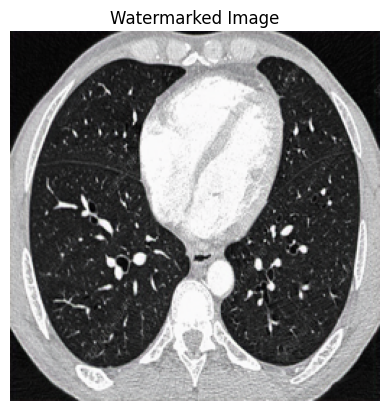

In [9]:
from keras.layers import TFSMLayer
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# ------------------ LOAD MODELS AS TFSMLayer ------------------
encoder = TFSMLayer("encoder_saved_model", call_endpoint="serve")
decoder = TFSMLayer("decoder_saved_model", call_endpoint="serve")

# ------------------ UPLOAD HOST IMAGE ------------------
print("Upload host image (this will also be used as watermark)")
uploaded_image = files.upload()
host_image_path = list(uploaded_image.keys())[0]

# Open and convert image to RGB
host_img = Image.open(host_image_path).convert("RGB")

# Resize to 256x256
host_img = host_img.resize((256, 256))

# Convert to numpy array and normalize
host_array = np.array(host_img) / 255.0
wm_array = host_array.copy()  # same image as watermark

# Prepare input
input_array = np.concatenate([host_array, wm_array], axis=-1)
input_array = np.expand_dims(input_array, axis=0)

# Predict watermarked image
watermarked_array = encoder(input_array)
watermarked_array = np.clip(watermarked_array[0].numpy(), 0, 1)

# Convert back to image and display
watermarked_img = Image.fromarray((watermarked_array * 255).astype(np.uint8))
plt.imshow(watermarked_img)
plt.axis("off")
plt.title("Watermarked Image")
plt.show()


Upload host image


Saving host.png to host (5).png
Upload watermark image


Saving watermark.png to watermark (1).png


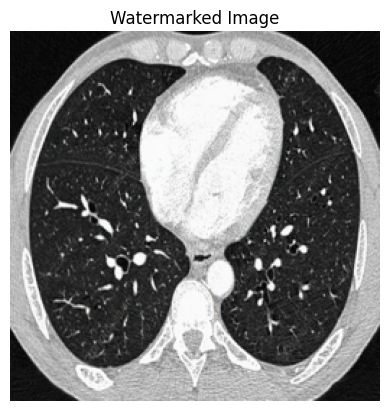

In [11]:
from keras.layers import TFSMLayer
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# ------------------ LOAD MODELS AS TFSMLayer ------------------
encoder = TFSMLayer("encoder_saved_model", call_endpoint="serve")
decoder = TFSMLayer("decoder_saved_model", call_endpoint="serve")

# ------------------ UPLOAD HOST IMAGE ------------------
print("Upload host image")
uploaded_host = files.upload()
host_image_path = list(uploaded_host.keys())[0]

# Open and convert host image to RGB
host_img = Image.open(host_image_path).convert("RGB")
host_img = host_img.resize((256, 256))
host_array = np.array(host_img) / 255.0

# ------------------ UPLOAD WATERMARK IMAGE ------------------
print("Upload watermark image")
uploaded_wm = files.upload()
watermark_image_path = list(uploaded_wm.keys())[0]

# Open and convert watermark image to RGB
wm_img = Image.open(watermark_image_path).convert("RGB")
wm_img = wm_img.resize((256, 256))
wm_array = np.array(wm_img) / 255.0

# ------------------ PREPARE MODEL INPUT ------------------
input_array = np.concatenate([host_array, wm_array], axis=-1)  # shape: (256,256,6)
input_array = np.expand_dims(input_array, axis=0)

# ------------------ PREDICT WATERMARKED IMAGE ------------------
watermarked_array = encoder(input_array)
watermarked_array = np.clip(watermarked_array[0].numpy(), 0, 1)

# Convert back to image and display
watermarked_img = Image.fromarray((watermarked_array * 255).astype(np.uint8))
plt.imshow(watermarked_img)
plt.axis("off")
plt.title("Watermarked Image")
plt.show()


In [12]:
import shutil
from google.colab import files

# ------------------ ZIP ENCODER MODEL ------------------
encoder_dir = "encoder_saved_model"  # folder name of your encoder model
encoder_zip = "encoder_model.zip"    # output zip filename
shutil.make_archive("encoder_model", 'zip', encoder_dir)

# Download the zip
files.download(encoder_zip)

# ------------------ ZIP DECODER MODEL ------------------
decoder_dir = "decoder_saved_model"  # folder name of your decoder model
decoder_zip = "decoder_model.zip"    # output zip filename
shutil.make_archive("decoder_model", 'zip', decoder_dir)

# Download the zip
files.download(decoder_zip)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Upload host image


Saving 7 (2) - Copy.png to 7 (2) - Copy.png
Upload watermark image


Saving watermark.png to watermark (2).png


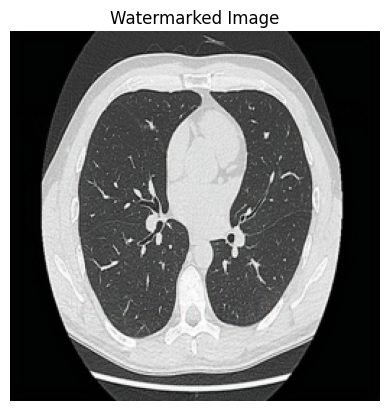

In [13]:
from keras.layers import TFSMLayer
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# ------------------ LOAD MODELS AS TFSMLayer ------------------
encoder = TFSMLayer("encoder_saved_model", call_endpoint="serve")
decoder = TFSMLayer("decoder_saved_model", call_endpoint="serve")

# ------------------ UPLOAD HOST IMAGE ------------------
print("Upload host image")
uploaded_host = files.upload()
host_image_path = list(uploaded_host.keys())[0]

# Open and convert host image to RGB
host_img = Image.open(host_image_path).convert("RGB")
host_img = host_img.resize((256, 256))
host_array = np.array(host_img) / 255.0

# ------------------ UPLOAD WATERMARK IMAGE ------------------
print("Upload watermark image")
uploaded_wm = files.upload()
watermark_image_path = list(uploaded_wm.keys())[0]

# Open and convert watermark image to RGB
wm_img = Image.open(watermark_image_path).convert("RGB")
wm_img = wm_img.resize((256, 256))
wm_array = np.array(wm_img) / 255.0

# ------------------ PREPARE MODEL INPUT ------------------
input_array = np.concatenate([host_array, wm_array], axis=-1)  # shape: (256,256,6)
input_array = np.expand_dims(input_array, axis=0)

# ------------------ PREDICT WATERMARKED IMAGE ------------------
watermarked_array = encoder(input_array)
watermarked_array = np.clip(watermarked_array[0].numpy(), 0, 1)

# Convert back to image and display
watermarked_img = Image.fromarray((watermarked_array * 255).astype(np.uint8))
plt.imshow(watermarked_img)
plt.axis("off")
plt.title("Watermarked Image")
plt.show()


Upload host image


Saving host.png to host (6).png
Upload watermark image


Saving watermarked_image_host.png to watermarked_image_host.png


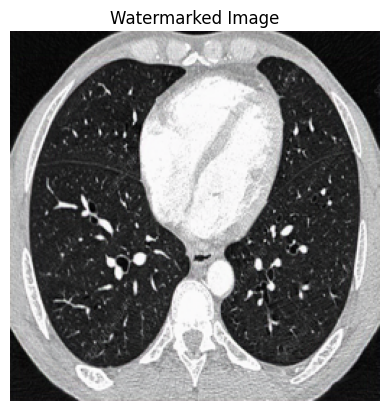

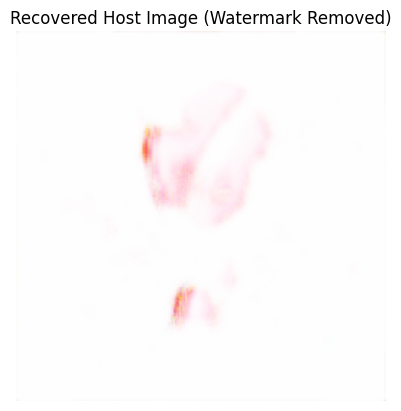

In [15]:
from keras.layers import TFSMLayer
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# ------------------ LOAD MODELS AS TFSMLayer ------------------
encoder = TFSMLayer("encoder_saved_model", call_endpoint="serve")
decoder = TFSMLayer("decoder_saved_model", call_endpoint="serve")

# ------------------ UPLOAD HOST IMAGE ------------------
print("Upload host image")
uploaded_host = files.upload()
host_image_path = list(uploaded_host.keys())[0]

# Open and convert host image to RGB
host_img = Image.open(host_image_path).convert("RGB")
host_img = host_img.resize((256, 256))
host_array = np.array(host_img) / 255.0

# ------------------ UPLOAD WATERMARK IMAGE ------------------
print("Upload watermark image")
uploaded_wm = files.upload()
watermark_image_path = list(uploaded_wm.keys())[0]

# Open and convert watermark image to RGB
wm_img = Image.open(watermark_image_path).convert("RGB")
wm_img = wm_img.resize((256, 256))
wm_array = np.array(wm_img) / 255.0

# ------------------ PREPARE MODEL INPUT FOR ENCODER ------------------
input_array = np.concatenate([host_array, wm_array], axis=-1)  # shape: (256,256,6)
input_array = np.expand_dims(input_array, axis=0)

# ------------------ PREDICT WATERMARKED IMAGE ------------------
watermarked_array = encoder(input_array)
watermarked_array = np.clip(watermarked_array[0].numpy(), 0, 1)

# Convert back to image and display
watermarked_img = Image.fromarray((watermarked_array * 255).astype(np.uint8))
plt.imshow(watermarked_img)
plt.axis("off")
plt.title("Watermarked Image")
plt.show()

# ------------------ USE DECODER TO REMOVE WATERMARK ------------------
# Decoder expects the watermarked image as input
decoder_input = np.expand_dims(watermarked_array, axis=0)
recovered_host_array = decoder(decoder_input)
recovered_host_array = np.clip(recovered_host_array[0].numpy(), 0, 1)

# Convert back to image and display
recovered_host_img = Image.fromarray((recovered_host_array * 255).astype(np.uint8))
plt.imshow(recovered_host_img)
plt.axis("off")
plt.title("Recovered Host Image (Watermark Removed)")
plt.show()


In [17]:
from PIL import Image
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from google.colab import files

# ------------------ UPLOAD IMAGES ------------------
print("Upload the original host image")
uploaded_host = files.upload()
host_image_path = list(uploaded_host.keys())[0]

print("Upload the watermarked or recovered image")
uploaded_test = files.upload()
test_image_path = list(uploaded_test.keys())[0]

# ------------------ OPEN AND PREPROCESS IMAGES ------------------
host_img = Image.open(host_image_path).convert("RGB").resize((256, 256))
test_img = Image.open(test_image_path).convert("RGB").resize((256, 256))

host_array = np.array(host_img) / 255.0
test_array = np.array(test_img) / 255.0

# ------------------ COMPUTE PSNR ------------------
psnr_value = psnr(host_array, test_array, data_range=1.0)
print(f"PSNR: {psnr_value:.2f} dB")

# ------------------ COMPUTE SSIM ------------------
ssim_value = ssim(host_array, test_array, data_range=1.0, channel_axis=2)
print(f"SSIM: {ssim_value:.4f}")


Upload the original host image


Saving host.png to host (8).png
Upload the watermarked or recovered image


Saving watermarked_image_host.png to watermarked_image_host (2).png
PSNR: 8.79 dB
SSIM: 0.1355


Upload host image


Saving host.png to host (9).png
Upload watermark image


Saving watermark.png to watermark (3).png


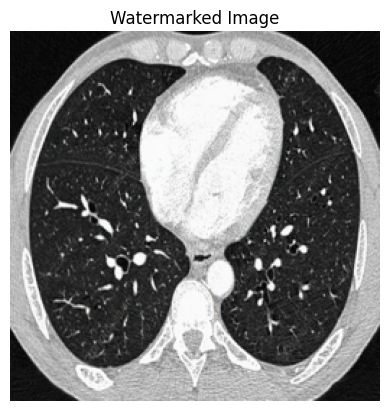

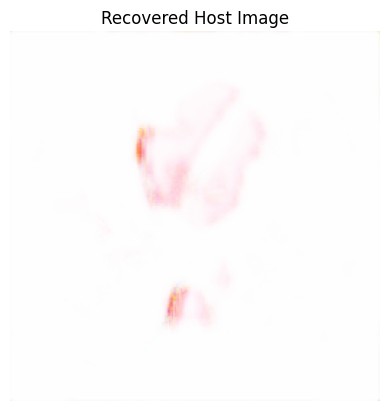

PSNR: 3.81 dB
SSIM: 0.1241


In [18]:
from keras.layers import TFSMLayer
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# ------------------ LOAD MODELS AS TFSMLayer ------------------

encoder = TFSMLayer("encoder_saved_model", call_endpoint="serve")
decoder = TFSMLayer("decoder_saved_model", call_endpoint="serve")

# ------------------ UPLOAD HOST IMAGE ------------------

print("Upload host image")
uploaded_host = files.upload()
host_image_path = list(uploaded_host.keys())[0]

host_img = Image.open(host_image_path).convert("RGB")
host_img = host_img.resize((256, 256))
host_array = np.array(host_img) / 255.0

# ------------------ UPLOAD WATERMARK IMAGE ------------------

print("Upload watermark image")
uploaded_wm = files.upload()
watermark_image_path = list(uploaded_wm.keys())[0]

wm_img = Image.open(watermark_image_path).convert("RGB")
wm_img = wm_img.resize((256, 256))
wm_array = np.array(wm_img) / 255.0

# ------------------ ENCODE (WATERMARK) ------------------

input_array = np.concatenate([host_array, wm_array], axis=-1)
input_array = np.expand_dims(input_array, axis=0)

watermarked_array = encoder(input_array)
watermarked_array = np.clip(watermarked_array[0].numpy(), 0, 1)
watermarked_img = Image.fromarray((watermarked_array * 255).astype(np.uint8))

plt.imshow(watermarked_img)
plt.axis("off")
plt.title("Watermarked Image")
plt.show()

# ------------------ DECODE (RECOVER HOST) ------------------

watermarked_input = np.expand_dims(watermarked_array, axis=0)
recovered_array = decoder(watermarked_input)
recovered_array = np.clip(recovered_array[0].numpy(), 0, 1)
recovered_img = Image.fromarray((recovered_array * 255).astype(np.uint8))

plt.imshow(recovered_img)
plt.axis("off")
plt.title("Recovered Host Image")
plt.show()

# ------------------ CALCULATE PSNR & SSIM ------------------

psnr_value = psnr(host_array, recovered_array, data_range=1.0)
ssim_value = ssim(host_array, recovered_array, channel_axis=2, data_range=1.0)

print(f"PSNR: {psnr_value:.2f} dB")
print(f"SSIM: {ssim_value:.4f}")


Upload host image


Saving host.png to host (10).png
Upload watermark image


Saving watermark.png to watermark (4).png


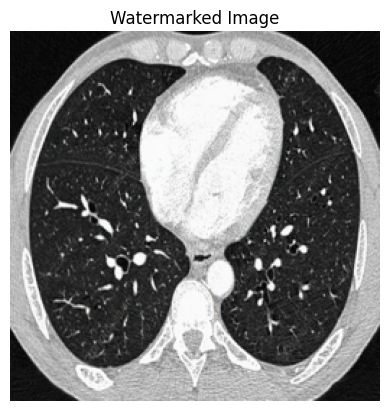

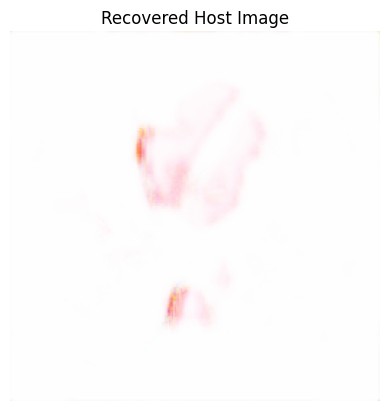

PSNR: 3.81 dB
SSIM: 0.1241


In [19]:
from keras.layers import TFSMLayer
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# ------------------ LOAD MODELS AS TFSMLayer ------------------

encoder = TFSMLayer("encoder_saved_model", call_endpoint="serve")
decoder = TFSMLayer("decoder_saved_model", call_endpoint="serve")

# ------------------ UPLOAD HOST IMAGE ------------------

print("Upload host image")
uploaded_host = files.upload()
host_image_path = list(uploaded_host.keys())[0]

host_img = Image.open(host_image_path).convert("RGB")
host_img = host_img.resize((256, 256))
host_array = np.array(host_img).astype(np.float32) / 255.0  # ensure float32

# ------------------ UPLOAD WATERMARK IMAGE ------------------

print("Upload watermark image")
uploaded_wm = files.upload()
watermark_image_path = list(uploaded_wm.keys())[0]

wm_img = Image.open(watermark_image_path).convert("RGB")
wm_img = wm_img.resize((256, 256))
wm_array = np.array(wm_img).astype(np.float32) / 255.0

# ------------------ ENCODE (WATERMARK) ------------------

input_array = np.concatenate([host_array, wm_array], axis=-1)  # shape: (256,256,6)
input_array = np.expand_dims(input_array, axis=0).astype(np.float32)

watermarked_array = encoder(input_array)
watermarked_array = np.clip(watermarked_array[0].numpy(), 0, 1)
watermarked_img = Image.fromarray((watermarked_array * 255).astype(np.uint8))

plt.imshow(watermarked_img)
plt.axis("off")
plt.title("Watermarked Image")
plt.show()

# ------------------ DECODE (RECOVER HOST) ------------------

# Prepare input same as training (concatenate host+watermark if needed)

decoder_input = np.expand_dims(watermarked_array, axis=0).astype(np.float32)
recovered_array = decoder(decoder_input)
recovered_array = np.clip(recovered_array[0].numpy(), 0, 1)
recovered_img = Image.fromarray((recovered_array * 255).astype(np.uint8))

plt.imshow(recovered_img)
plt.axis("off")
plt.title("Recovered Host Image")
plt.show()

# ------------------ CALCULATE PSNR & SSIM ------------------

# Ensure both arrays are float32 and in range [0,1]

psnr_value = psnr(host_array, recovered_array, data_range=1.0)
ssim_value = ssim(host_array, recovered_array, channel_axis=2, data_range=1.0)

print(f"PSNR: {psnr_value:.2f} dB")
print(f"SSIM: {ssim_value:.4f}")


Upload host image


Saving host.png to host (11).png
Upload watermark image


Saving watermark.png to watermark (5).png


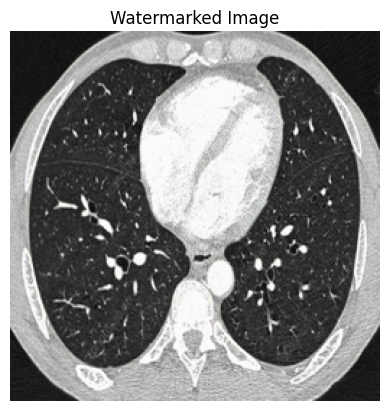

TypeError: Exception encountered when calling TFSMLayer.call().

[1mBinding inputs to tf.function failed due to `Can not cast TensorSpec(shape=(1, 256, 256, 6), dtype=tf.float32, name='keras_tensor_40') to TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_40')`. Received args: (<tf.Tensor: shape=(1, 256, 256, 6), dtype=float32, numpy=
array([[[[-0.84012747, -0.85509384, -0.85586846,  1.        ,
           1.        ,  1.        ],
         [-0.8208252 , -0.8206881 , -0.8150808 ,  1.        ,
           1.        ,  1.        ],
         [-0.8073654 , -0.8064542 , -0.77785677,  1.        ,
           1.        ,  1.        ],
         ...,
         [-0.8566457 , -0.8527285 , -0.8018008 ,  1.        ,
           1.        ,  1.        ],
         [-0.8688061 , -0.86595184, -0.85516036,  1.        ,
           1.        ,  1.        ],
         [-0.83979553, -0.8330698 , -0.81336486,  1.        ,
           1.        ,  1.        ]],

        [[-0.8252358 , -0.8290676 , -0.8291893 ,  1.        ,
           1.        ,  1.        ],
         [-0.8081958 , -0.8081831 , -0.8080508 ,  1.        ,
           1.        ,  1.        ],
         [-0.80797565, -0.8081609 , -0.8078577 ,  1.        ,
           1.        ,  1.        ],
         ...,
         [-0.83985126, -0.8429397 , -0.8396663 ,  1.        ,
           1.        ,  1.        ],
         [-0.811603  , -0.81433123, -0.80481076,  1.        ,
           1.        ,  1.        ],
         [-0.76546276, -0.76764387, -0.7543626 ,  1.        ,
           1.        ,  1.        ]],

        [[-0.8477776 , -0.85038096, -0.8503505 ,  1.        ,
           1.        ,  1.        ],
         [-0.81527483, -0.81521964, -0.8152268 ,  1.        ,
           1.        ,  1.        ],
         [-0.80115676, -0.80096453, -0.801123  ,  1.        ,
           1.        ,  1.        ],
         ...,
         [-0.80749923, -0.8070553 , -0.80780476,  1.        ,
           1.        ,  1.        ],
         [-0.78590995, -0.78102666, -0.78563786,  1.        ,
           1.        ,  1.        ],
         [-0.7786985 , -0.77052397, -0.7687316 ,  1.        ,
           1.        ,  1.        ]],

        ...,

        [[-0.763989  , -0.77265733, -0.77104247,  1.        ,
           1.        ,  1.        ],
         [-0.81503415, -0.8151489 , -0.81519014,  1.        ,
           1.        ,  1.        ],
         [-0.7793642 , -0.7799496 , -0.7799741 ,  1.        ,
           1.        ,  1.        ],
         ...,
         [-0.7027561 , -0.7089285 , -0.709371  ,  1.        ,
           1.        ,  1.        ],
         [-0.7561401 , -0.7542524 , -0.75843143,  1.        ,
           1.        ,  1.        ],
         [-0.8133662 , -0.7961881 , -0.80654585,  1.        ,
           1.        ,  1.        ]],

        [[-0.7311435 , -0.76543874, -0.7626545 ,  1.        ,
           1.        ,  1.        ],
         [-0.79286087, -0.7934585 , -0.793568  ,  1.        ,
           1.        ,  1.        ],
         [-0.79963547, -0.80111635, -0.800958  ,  1.        ,
           1.        ,  1.        ],
         ...,
         [-0.7980923 , -0.8080368 , -0.80710393,  1.        ,
           1.        ,  1.        ],
         [-0.81227535, -0.82087034, -0.8126121 ,  1.        ,
           1.        ,  1.        ],
         [-0.7866607 , -0.7788969 , -0.7685753 ,  1.        ,
           1.        ,  1.        ]],

        [[-0.7044913 , -0.7327479 , -0.7006739 ,  1.        ,
           1.        ,  1.        ],
         [-0.7344755 , -0.75414544, -0.74307656,  1.        ,
           1.        ,  1.        ],
         [-0.73271203, -0.7436105 , -0.7431933 ,  1.        ,
           1.        ,  1.        ],
         ...,
         [-0.72857034, -0.7564685 , -0.7431008 ,  1.        ,
           1.        ,  1.        ],
         [-0.736295  , -0.7657738 , -0.7421797 ,  1.        ,
           1.        ,  1.        ],
         [-0.705005  , -0.7221018 , -0.67091995,  1.        ,
           1.        ,  1.        ]]]], dtype=float32)>,) and kwargs: {} for signature: (args_0: TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_40')).[0m

Arguments received by TFSMLayer.call():
  • inputs=tf.Tensor(shape=(1, 256, 256, 6), dtype=float32)
  • training=False
  • kwargs=<class 'inspect._empty'>

In [20]:
from keras.layers import TFSMLayer
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# ------------------ LOAD MODELS ------------------

encoder = TFSMLayer("encoder_saved_model", call_endpoint="serve")
decoder = TFSMLayer("decoder_saved_model", call_endpoint="serve")

# ------------------ UPLOAD HOST IMAGE ------------------

print("Upload host image")
uploaded_host = files.upload()
host_image_path = list(uploaded_host.keys())[0]

host_img = Image.open(host_image_path).convert("RGB")
host_img = host_img.resize((256, 256))
host_array = np.array(host_img).astype(np.float32) / 255.0
host_array = host_array * 2 - 1  # scale to [-1, 1]

# ------------------ UPLOAD WATERMARK IMAGE ------------------

print("Upload watermark image")
uploaded_wm = files.upload()
watermark_image_path = list(uploaded_wm.keys())[0]

wm_img = Image.open(watermark_image_path).convert("RGB")
wm_img = wm_img.resize((256, 256))
wm_array = np.array(wm_img).astype(np.float32) / 255.0
wm_array = wm_array * 2 - 1  # scale to [-1, 1]

# ------------------ ENCODE (WATERMARK) ------------------

input_array = np.concatenate([host_array, wm_array], axis=-1)  # shape: (256,256,6)
input_array = np.expand_dims(input_array, axis=0).astype(np.float32)

watermarked_array = encoder(input_array)
watermarked_array = watermarked_array[0].numpy()
watermarked_img = ((watermarked_array + 1) / 2 * 255).astype(np.uint8)
plt.imshow(watermarked_img)
plt.axis("off")
plt.title("Watermarked Image")
plt.show()

# ------------------ DECODE (RECOVER HOST) ------------------

# Decoder input: concat watermarked + watermark (same as training)

decoder_input = np.concatenate([watermarked_array, wm_array], axis=-1)
decoder_input = np.expand_dims(decoder_input, axis=0).astype(np.float32)

recovered_array = decoder(decoder_input)
recovered_array = recovered_array[0].numpy()
recovered_array = np.clip((recovered_array + 1) / 2, 0, 1)  # scale back to [0,1]
recovered_img = (recovered_array * 255).astype(np.uint8)

plt.imshow(recovered_img)
plt.axis("off")
plt.title("Recovered Host Image")
plt.show()

# ------------------ CALCULATE PSNR & SSIM ------------------

psnr_value = psnr((host_array + 1)/2, recovered_array, data_range=1.0)
ssim_value = ssim((host_array + 1)/2, recovered_array, channel_axis=2, data_range=1.0)

print(f"PSNR: {psnr_value:.2f} dB")
print(f"SSIM: {ssim_value:.4f}")


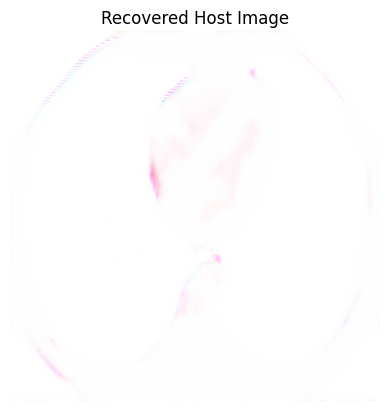

In [21]:
# ------------------ DECODE (RECOVER HOST) ------------------

# Pass only the watermarked image to decoder

decoder_input = np.expand_dims(watermarked_array, axis=0).astype(np.float32)  # shape: (1,256,256,3)

recovered_array = decoder(decoder_input)
recovered_array = recovered_array[0].numpy()
recovered_array = np.clip((recovered_array + 1) / 2, 0, 1)  # scale back to [0,1]
recovered_img = (recovered_array * 255).astype(np.uint8)

plt.imshow(recovered_img)
plt.axis("off")
plt.title("Recovered Host Image")
plt.show()
